# 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
import json
import math
from typing import List, Optional
!pip install parsel
!pip install scrapfly-sdk
from parsel import Selector
from typing_extensions import TypedDict
from scrapfly import ScrapflyClient, ScrapeConfig




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.3 MB/s eta 0:00:00


In [16]:
import re
import pandas as pd
from bs4 import BeautifulSoup
from scrapfly import ScrapflyClient, ScrapeConfig

client = ScrapflyClient("scp-live-e845369bb67a4b8298658e087cb182e5")

def find_properties(state: str, city: str, pages: int = 30):
    house_info_list = []
    for page in range(1, pages + 1):
        print(f"Scraping page {page} for {city}, {state}")
        page_url = f"https://www.realtor.com/realestateandhomes-search/{city}_{state.upper()}/pg-{page}"

        scrape_result = client.scrape(ScrapeConfig(url=page_url, country="US", asp=True))
        html_content = scrape_result.content

        soup = BeautifulSoup(html_content, 'html.parser')
        properties_info = soup.find_all('li', attrs={'data-testid': re.compile(r'property-meta-.+')})
        properties_set = set([info.find_parent('ul') for info in properties_info])


        for prop in properties_set:
            if prop:
                beds = prop.find('li', {'data-testid': 'property-meta-beds'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-beds'}) else 'N/A'
                baths = prop.find('li', {'data-testid': 'property-meta-baths'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-baths'}) else 'N/A'
                sqft = prop.find('li', {'data-testid': 'property-meta-sqft'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-sqft'}) else 'N/A'
                lot_size = prop.find('li', {'data-testid': 'property-meta-lot-size'}).find('span', {'data-testid': 'meta-value'}).get_text(strip=True) if prop.find('li', {'data-testid': 'property-meta-lot-size'}) else 'N/A'

                price_wrapper = prop.find_previous_sibling('div', class_='price-wrapper')
                price = price_wrapper.find('div', {'data-testid': 'card-price'}).get_text(strip=True) if price_wrapper else 'N/A'

                house_info = {
                    'Price': price,
                    'Beds': beds,
                    'Baths': baths,
                    'Area (sqft)': sqft,
                    'Lot Size': lot_size
                }

                house_info_list.append(house_info)

    return house_info_list




In [17]:

locations = [
    ("Los-Angeles","CA"),
    ("San-Francisco", "CA"),
    ("New-York", "NY"),
    ("Seattle", "WA"),
    ("Dallas", "TX")
]

dfs = {}

for city, state in locations:
    house_info_list = find_properties(state, city, 30)
    dfs[city] = pd.DataFrame(house_info_list)

print(dfs["San-Francisco"])


Scraping page 1 for Los-Angeles, CA
Scraping page 2 for Los-Angeles, CA
Scraping page 3 for Los-Angeles, CA
Scraping page 4 for Los-Angeles, CA
Scraping page 5 for Los-Angeles, CA
Scraping page 6 for Los-Angeles, CA
Scraping page 7 for Los-Angeles, CA
Scraping page 8 for Los-Angeles, CA
Scraping page 9 for Los-Angeles, CA
Scraping page 10 for Los-Angeles, CA
Scraping page 11 for Los-Angeles, CA
Scraping page 12 for Los-Angeles, CA
Scraping page 13 for Los-Angeles, CA
Scraping page 14 for Los-Angeles, CA
Scraping page 15 for Los-Angeles, CA
Scraping page 16 for Los-Angeles, CA
Scraping page 17 for Los-Angeles, CA
Scraping page 18 for Los-Angeles, CA
Scraping page 19 for Los-Angeles, CA
Scraping page 20 for Los-Angeles, CA
Scraping page 21 for Los-Angeles, CA
Scraping page 22 for Los-Angeles, CA
Scraping page 23 for Los-Angeles, CA
Scraping page 24 for Los-Angeles, CA
Scraping page 25 for Los-Angeles, CA
Scraping page 26 for Los-Angeles, CA
Scraping page 27 for Los-Angeles, CA
Scraping p

In [20]:
import pandas as pd

for city, df in dfs.items():
    df['City'] = city

all_cities_df = pd.concat(dfs.values(), ignore_index=True)

all_cities_df.to_csv('real_estate_data.csv', index=False)
print("The merged DataFrame has been saved to real_estate_data.csv.")


The merged DataFrame has been saved to real_estate_data.csv.


# 2

https://api.developer.attomdata.com/docs#!/Valuation32V1/assessmentHistoryDetailID

In [52]:


url ="https://api.gateway.attomdata.com/propertyapi/v1.0.0/property/id?geoid=PL0820000&minBeds=1"
headers = {
    "accept": "application/json",
    "apikey": "37b77047fa1778ca3c56c8871e08a387"
}
response = requests.get(url, headers=headers)
json_data=response.json()

ids = [property["identifier"]["Id"] for property in json_data["property"]]

ids

[143367,
 143382,
 143899,
 144393,
 144394,
 145233,
 145234,
 145235,
 146764,
 147146]

In [65]:

for attomId in ids:
    url = "https://api.gateway.attomdata.com/propertyapi/v1.0.0/assessmenthistory/detail"
    params = {"attomId": attomId}
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        json_data = response.json()
        assessment_history = json_data['property'][0]['assessmenthistory']

        historical_prices = []
        for history in assessment_history:
            assessed_info = {
                'year': history.get('tax', {}).get('assessorYear'),
                'assessed_improvement_value': history.get('assessed', {}).get('assdImprValue'),
                'assessed_land_value': history.get('assessed', {}).get('assdLandValue'),
                'total_assessed_value': history.get('assessed', {}).get('assdTtlValue'),
                'market_improvement_value': history.get('market', {}).get('mktImprValue'),
                'market_land_value': history.get('market', {}).get('mktLandValue'),
                'total_market_value': history.get('market', {}).get('mktTtlValue'),
                'tax_amount': history.get('tax', {}).get('taxAmt'),
            }
            historical_prices.append(assessed_info)

        df = pd.DataFrame(historical_prices)
        csv_file_path = f'attomId_{attomId}_historical_prices.csv'
        df.to_csv(csv_file_path, index=False)
    else:
        print(f"Error fetching historical information for attomId {attomId}: {response.status_code}")

# 3

In [79]:

import pandas as pd

# Load the dataset
file_path = 'real_estate_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and content
data.head()


,Price,Beds,Baths,Area (sqft),Lot Size,City
0,"$2,595,000",3,3.5,"2,814",0.26,Los-Angeles
1,"$97,500",2,2,"1,080",NaN,Los-Angeles
2,"$126,000,000",8,20,"30,610",9.9,Los-Angeles
3,"$9,500,000",5,7,"9,375",0.74,Los-Angeles
4,"$139,000,000",12,17,NaN,2.08,Los-Angeles


In [80]:

# Remove currency symbols and commas from 'Price', then convert to numeric
data['Price'] = data['Price'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Beds', 'Baths', and 'Lot Size' to numeric, handling missing values as NaN
columns_to_numeric = ['Beds', 'Baths', 'Lot Size']
data[columns_to_numeric] = data[columns_to_numeric].replace('None', np.nan).apply(pd.to_numeric, errors='coerce')

# Remove commas from 'Area (sqft)' and convert to numeric
data['Area (sqft)'] = data['Area (sqft)'].str.replace(',', '').astype(float)

# Re-check the cleaned data
cleaned_data_info = data.info()
cleaned_data_head = data.head()

cleaned_data_info, cleaned_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        1199 non-null   float64
 1   Beds         1131 non-null   float64
 2   Baths        1076 non-null   float64
 3   Area (sqft)  1097 non-null   float64
 4   Lot Size     339 non-null    float64
 5   City         1199 non-null   object 
dtypes: float64(5), object(1)
memory usage: 56.3+ KB


(None,
          Price  Beds  Baths  Area (sqft)  Lot Size         City
 0    2595000.0   3.0    3.5       2814.0      0.26  Los-Angeles
 1      97500.0   2.0    2.0       1080.0       NaN  Los-Angeles
 2  126000000.0   8.0   20.0      30610.0      9.90  Los-Angeles
 3    9500000.0   5.0    7.0       9375.0      0.74  Los-Angeles
 4  139000000.0  12.0   17.0          NaN      2.08  Los-Angeles)

In [81]:

data_cleaned = data.dropna()

data_cleaned_info = data_cleaned.info()
data_cleaned_head = data_cleaned.head()

data_cleaned_info, data_cleaned_head


<class 'pandas.core.frame.DataFrame'>
Int64Index: 279 entries, 0 to 1197
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        279 non-null    float64
 1   Beds         279 non-null    float64
 2   Baths        279 non-null    float64
 3   Area (sqft)  279 non-null    float64
 4   Lot Size     279 non-null    float64
 5   City         279 non-null    object 
dtypes: float64(5), object(1)
memory usage: 15.3+ KB


(None,
           Price  Beds  Baths  Area (sqft)  Lot Size         City
 0     2595000.0   3.0    3.5       2814.0      0.26  Los-Angeles
 2   126000000.0   8.0   20.0      30610.0      9.90  Los-Angeles
 3     9500000.0   5.0    7.0       9375.0      0.74  Los-Angeles
 9     3950000.0   3.0    4.5       3516.0      4.51  Los-Angeles
 10   49500000.0   9.0   18.0      21000.0      3.60  Los-Angeles)

In [82]:
# Calculate price per square foot
data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']

# Display the first few rows of the data with the calculated price per square foot
data_cleaned[['Price', 'Area (sqft)', 'Price_per_sqft']].head()


<ipython-input-82-29ce46b9d05c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']


,Price,Area (sqft),Price_per_sqft
0,2595000.0,2814.0,922.174840
2,126000000.0,30610.0,4116.301862
3,9500000.0,9375.0,1013.333333
9,3950000.0,3516.0,1123.435722
10,49500000.0,21000.0,2357.142857


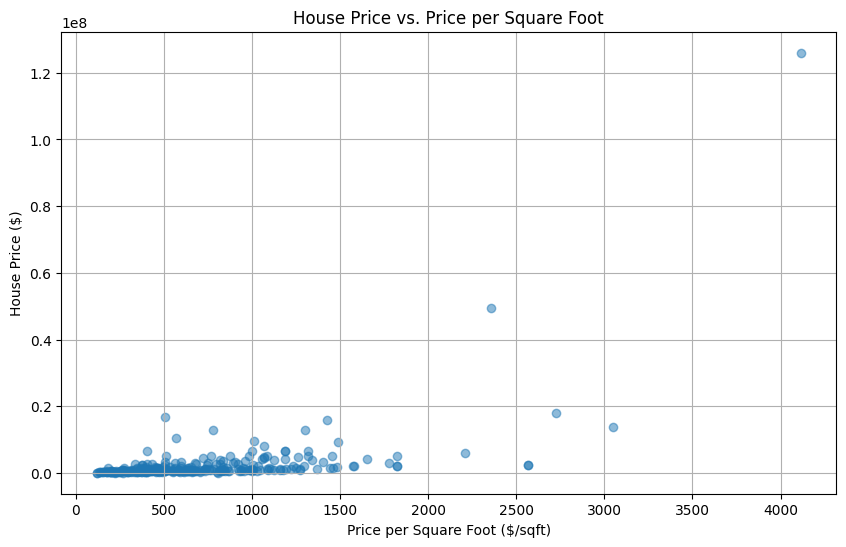

In [83]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['Price_per_sqft'], data_cleaned['Price'], alpha=0.5)
plt.title('House Price vs. Price per Square Foot')
plt.xlabel('Price per Square Foot ($/sqft)')
plt.ylabel('House Price ($)')
plt.grid(True)
plt.show()


<ipython-input-84-b1e693dbe6ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']


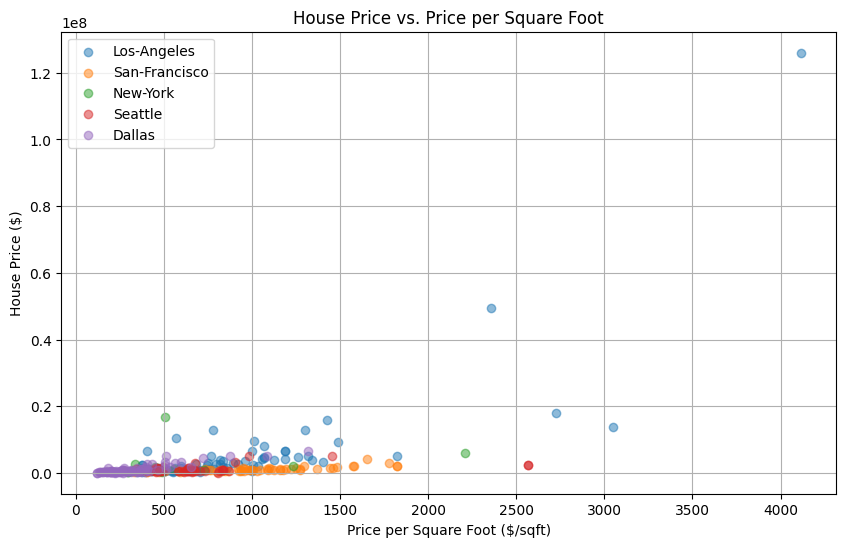

In [84]:
import matplotlib.pyplot as plt

# Calculate price per square foot considering the city
data_cleaned['Price_per_sqft'] = data_cleaned['Price'] / data_cleaned['Area (sqft)']

# Create a scatter plot with different colors for each city
plt.figure(figsize=(10, 6))
for city in data_cleaned['City'].unique():
    city_data = data_cleaned[data_cleaned['City'] == city]
    plt.scatter(city_data['Price_per_sqft'], city_data['Price'], alpha=0.5, label=city)

plt.title('House Price vs. Price per Square Foot')
plt.xlabel('Price per Square Foot ($/sqft)')
plt.ylabel('House Price ($)')
plt.legend()
plt.grid(True)
plt.show()


Linear Regression Train RMSE: 5762353.74866507
Linear Regression Test RMSE: 2850561.0101804333
Multiple Linear Regression Train RMSE: 5762353.74866507
Multiple Linear Regression Test RMSE: 2850561.0101804333


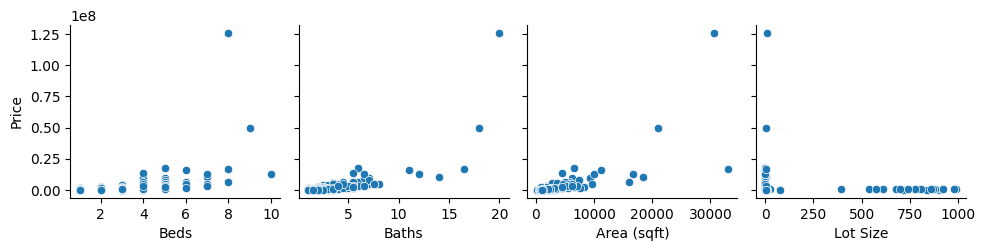

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Select relevant features (factors) and target variable (price)
X = data_cleaned[['Beds', 'Baths', 'Area (sqft)', 'Lot Size']]
y = data_cleaned['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Train multiple linear regression model
multiple_linear_reg_model = LinearRegression()
multiple_linear_reg_model.fit(X_train, y_train)

# Evaluate the models
linear_reg_train_rmse = mean_squared_error(y_train, linear_reg_model.predict(X_train), squared=False)
linear_reg_test_rmse = mean_squared_error(y_test, linear_reg_model.predict(X_test), squared=False)

multiple_linear_reg_train_rmse = mean_squared_error(y_train, multiple_linear_reg_model.predict(X_train), squared=False)
multiple_linear_reg_test_rmse = mean_squared_error(y_test, multiple_linear_reg_model.predict(X_test), squared=False)

# Display the root mean squared error (RMSE) for both models
print("Linear Regression Train RMSE:", linear_reg_train_rmse)
print("Linear Regression Test RMSE:", linear_reg_test_rmse)
print("Multiple Linear Regression Train RMSE:", multiple_linear_reg_train_rmse)
print("Multiple Linear Regression Test RMSE:", multiple_linear_reg_test_rmse)

# Visualize the relationships between factors and price using pairplot
sns.pairplot(data_cleaned, x_vars=['Beds', 'Baths', 'Area (sqft)', 'Lot Size'], y_vars=['Price'])
plt.show()


In [86]:
import pandas as pd

file_path = "attomId_147146_historical_prices.csv"
data = pd.read_csv(file_path)

print(data.head())


   year  assessed_improvement_value  assessed_land_value  \
0  2016                       12620                 1740   
1  2017                       15710                 3780   
2  2018                       15710                 3780   
3  2019                       19860                 4070   
4  2020                       19860                 4070   

   total_assessed_value  market_improvement_value  market_land_value  \
0                 14360                  158500.0            21900.0   
1                 19490                  218200.0            52500.0   
2                 19490                  218200.0            52500.0   
3                 23930                  277700.0            56900.0   
4                 23930                  277700.0            56900.0   

   total_market_value  tax_amount  
0              180400     1458.21  
1              270700     1893.14  
2              270700     1897.64  
3              334600     2204.33  
4              334600     

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

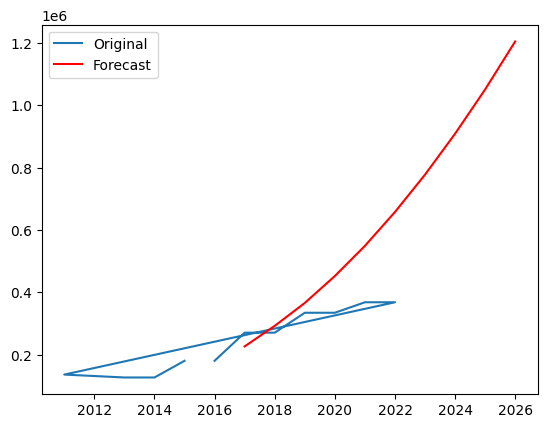

In [116]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

file_path = "attomId_147146_historical_prices.csv"
data = pd.read_csv(file_path)

data['year'] = pd.to_datetime(data['year'], format='%Y')
data.set_index('year', inplace=True)

model = ARIMA(data['total_market_value'], order=(1,3,1))
results = model.fit()

forecast = results.forecast(steps=10)

plt.plot(data.index, data['total_market_value'], label='Original')
plt.plot(pd.date_range(start=data.index[-1], periods=11, freq='Y')[1:], forecast, label='Forecast', color='red')
plt.legend()
plt.show()